## Imports and data-reading

In [1]:
import pandas as pd
# !pip install cvxopt
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import SVC
from sklearn import datasets

## Useful Functions for any part

### For SVM/SVC plotting

In [75]:
def plot_it_all_poly(train_X, train_y, test_X, test_y, reg_pam, ker_coeff_pam):

    ######################################### 3D plot ########################################
    Z = np.ones((len(reg_pam),len(ker_coeff_pam)))
    W = np.ones((len(reg_pam),len(ker_coeff_pam)))
    X, Y = np.meshgrid(reg_pam, ker_coeff_pam)


    for idxc, c in enumerate(reg_pam):
        for idxg, g in enumerate(ker_coeff_pam):
            ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly', C = c, gamma = g))]
            pipeline = Pipeline(ppl) 
            mod = pipeline
#             mod = svm.SVC(kernel='poly', C = c, gamma = g)
            mod.fit(train_X, np.ravel(train_y, order='C'))
            Z[idxc][idxg] = mod.score(train_X, train_y)
            W[idxc][idxg] = mod.score(test_X, test_y)

    # print(X, Y, Z, W, X.shape, Y.shape, Z.shape, W.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(np.log10(X), np.log10(Y), Z, rstride=1, cstride=1, label='train', color='blue' )
    ax.plot_wireframe(np.log10(X), np.log10(Y), W, rstride=1, cstride=1, label='test', color='red')
    ax.set_title('Poly kernel: C and Gamma Vs Accuracy')
    ax.set_xlabel('log(C)')
    ax.set_ylabel('log(Gamma)')

    plt.legend()
    plt.show()


    ######################################## My conventional plots ########################################
    for idxc, c in enumerate(reg_pam):
        E_score_train = []
        E_score_test = []

        for idxg, g in enumerate(ker_coeff_pam):
            ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly', C = c, gamma = g))]
            pipeline = Pipeline(ppl) 
            mod = pipeline
            #mod = svm.SVC(kernel='poly', C = c, gamma = g)
            mod.fit(train_X, np.ravel(train_y, order='C'))
            E_score_train.append(mod.score(train_X, train_y))
            E_score_test.append(mod.score(test_X, test_y))

        plt.plot(ker_coeff_pam, E_score_test, "r-", label="Test")
        plt.plot(ker_coeff_pam, E_score_train, "b-", label="Train")
        plt.xscale('log')
        plt.xlabel(r'$\Gamma$')
        plt.ylabel('Score')
        plt.legend()
        plt.title('Score for C=%s'%(c))
        plt.show()


        
def plot_it_all_linear(train_X, train_y, test_X, test_y, reg_pam):

    ######################################## My conventional plots ########################################
    E_score_train = []
    E_score_test = []

    for idxc, c in enumerate(reg_pam):    
        ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='linear', C = c))]
        pipeline = Pipeline(ppl) 
        mod = pipeline
#         mod = svm.SVC(kernel='poly', C = c, gamma = g)
        mod.fit(train_X, np.ravel(train_y, order='C'))
        E_score_train.append(mod.score(train_X, train_y))
        E_score_test.append(mod.score(test_X, test_y))

    plt.plot(reg_pam, E_score_test, "r-", label="Test")
    plt.plot(reg_pam, E_score_train, "b-", label="Train")
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Score')
    plt.legend()
#     plt.title('Score for C=%s'%(c))
    plt.show()

        
        
        
######################################## PLOTS FOR GRID SEARCH ########################################

def plot_search_results(grid):
    # Reference: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey=False,figsize=(len(params)*10,len(params)*2.5))
    fig.suptitle('Score per parameter')
    fig.text(0.085, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
#         m=np.array(masks[:i])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        if (x[-1]>=x[-2]*9):
            ax[i].set_xscale('log')
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
        ax[i].grid(True)

    plt.legend()
    plt.show()


    
def plot_search_results_linear(grid, reg_pam):
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']


    # print('mean_test_score: ', means_test)
    # print('std_test_score: ', stds_test)
    # print('mean_train_score: ', means_train)
    # print('std_train_score: ', stds_train)
    x = reg_pam
    y_1 = np.array(means_test)
    e_1 = np.array(stds_test)
    y_2 = np.array(means_train)
    e_2 = np.array(stds_train)
    plt.errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
    plt.errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
    plt.grid(True)
    plt.xscale('log')
    plt.title('Score Vs C')
    plt.legend(loc='lower right')
    plt.ylabel('Score')
    plt.xlabel('C')
    plt.show()

### For CVXOPT

In [83]:
# Reference: https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

def cvx_try(X, y, C, which='linear', kercf=1):
    
    y_temp = y.reshape(-1, 1)*1.
    
    if (which=='linear'):
        X_temp = y_temp*X
        H = np.dot(X_temp, X_temp.T)*1.
        P = matrix(H)
    elif (which=='poly'):
        temp = np.zeros((X.shape[0], X.shape[0]))
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                temp[i,j] = (1+np.dot(X[i], X[j]))**kercf
        P = matrix(np.outer(y,y)*temp)
                
    
    q = matrix(-np.ones((X.shape[0], 1)))
    A = matrix(y_temp.reshape(1, -1))
    b = matrix(np.zeros(1))
    G = matrix(np.r_[-1*(np.eye(X.shape[0])), np.eye(X.shape[0])])
    h = matrix(np.r_[np.zeros(X.shape[0]), np.ones(X.shape[0])*C])
    print(repr(q),repr(A),repr(b),repr(G),repr(h))
    solvers.options['show_progress'] = True
    sol = solvers.qp(P,q,G,h,A,b)
    lambs, _ = sol['x'], sol['primal objective']
    
    return np.array(lambs)

## Part 1A

### Data Import + Initialize

In [124]:
lab1 = 4
lab2 = 6
num_ft = 25
split_frac = 0.8
random_state = 69420
file_name = '2019EE10143.csv'


# Import
df = pd.read_csv(file_name, header=None)

#Convert to use
df_temp = df.loc[df[25].isin([lab1, lab2])]
print(len(df_temp))
df_temp.iloc[df_temp[25] == lab1, 25] = -1
df_temp.iloc[df_temp[25] == lab2, 25] = 1
df_temp = df_temp.sample(frac=1.)

train_df = df_temp[:int(split_frac*len(df_temp))]
test_df = df_temp[int(split_frac*len(df_temp)):]

X_train_temp = train_df.loc[:, [i for i in range(num_ft)]]
y_train_temp = train_df.loc[:, [25]]
X_test_temp = test_df.loc[:, [i for i in range(num_ft)]]
y_test_temp = test_df.loc[:, [25]]

# print(X_train_temp.head())
# print(y_train_temp.head())
# print(X_test_temp.head())
# print(y_test_temp.head())

print(len(X_train_temp), len(y_train_temp), len(X_test_temp), len(y_test_temp))


train_X = np.array(X_train_temp.values)
train_y = np.array(y_train_temp.values)
test_X = np.array(X_test_temp.values)
test_y = np.array(y_test_temp.values)

print (train_X.shape)
print (train_y.shape)
print (test_X.shape)
print (test_y.shape)

591
472 472 119 119
(472, 25)
(472, 1)
(119, 25)
(119, 1)


c:\users\vansh\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\vansh\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
c:\users\vansh\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

### Grid Search

In [125]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

low_reg, high_reg = -5,5
# low_cof, high_cof = -3,3
# low_deg, high_deg = 1, 6

reg_pam = np.logspace(low_reg, high_reg, num=1+high_reg-low_reg)
# ker_coeff_pam = np.logspace(low_cof, high_cof, num=1+high_cof-low_cof)
# deg_pam = np.linspace(low_deg, high_deg, 1+low_deg+high_deg)


ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='linear'))]
pipeline = Pipeline(ppl) 
parameters = {'SVM__C':reg_pam} #Linear
# parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam}
# parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam}
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, return_train_score=True)

grid.fit(train_X, np.ravel(train_y, order='C'))
print(grid.score(train_X, train_y))
print(grid.score(test_X, test_y))
print(grid.best_params_)

0.9915254237288136
0.9747899159663865
{'SVM__C': 0.01}


### Plottings

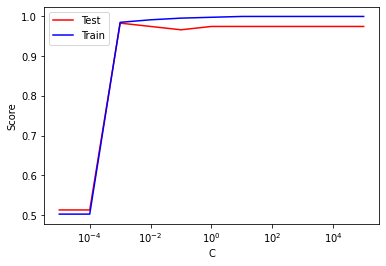

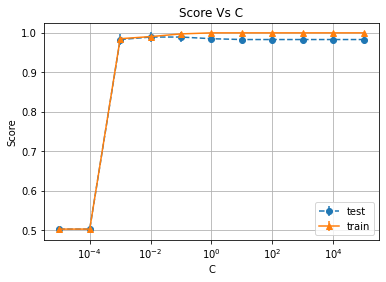

In [126]:
plot_it_all_linear(train_X, train_y, test_X, test_y, reg_pam)
plot_search_results_linear(grid, reg_pam)

In [130]:
pipeline = svm.SVC(kernel='linear', C=0.01)
pipeline.fit(train_X, np.ravel(train_y, order='C'))
print('w = ',pipeline.coef_)
print('b = ',pipeline.intercept_)
# print('Indices of support vectors = ', pipeline.support_)
# print('Support vectors = ', pipeline.support_vectors_)
# print('Number of support vectors for each class = ', pipeline.n_support_)
# print('Coefficients of the support vector in the decision function = ', np.abs(pipeline.dual_coef_))

w =  [[ 0.11717243 -0.40116018  0.11632333  0.30692205  0.03411372 -0.23536823
   0.33034117 -0.01774847 -0.13541525  0.00437062 -0.10100332  0.04296125
   0.0747433   0.02496386 -0.02533199 -0.00231244  0.26827029  0.02816113
   0.02320037  0.05914415  0.07584339 -0.01022711  0.06327853  0.04430409
  -0.08353974]]
b =  [-0.14984723]


## CVXOPT

In [128]:
idk = cvx_try(train_X, train_y, 0.01)
# idk

<472x1 matrix, tc='d'> <1x472 matrix, tc='d'> <1x1 matrix, tc='d'> <944x472 matrix, tc='d'> <944x1 matrix, tc='d'>
     pcost       dcost       gap    pres   dres
 0: -2.5764e+01 -8.8449e+00  3e+03  5e+01  2e-14
 1: -8.7158e-01 -8.7655e+00  5e+01  7e-01  2e-14
 2: -4.9729e-01 -5.5813e+00  8e+00  7e-02  3e-15
 3: -3.5112e-01 -1.0863e+00  8e-01  2e-03  1e-15
 4: -4.7274e-01 -7.2520e-01  3e-01  6e-04  6e-16
 5: -5.1730e-01 -6.4430e-01  1e-01  3e-04  5e-16
 6: -5.4308e-01 -5.9993e-01  6e-02  9e-05  5e-16
 7: -5.5491e-01 -5.8092e-01  3e-02  3e-05  5e-16
 8: -5.6226e-01 -5.6969e-01  7e-03  7e-06  5e-16
 9: -5.6496e-01 -5.6595e-01  1e-03  8e-07  5e-16
10: -5.6538e-01 -5.6540e-01  1e-05  8e-09  6e-16
11: -5.6539e-01 -5.6539e-01  1e-07  8e-11  6e-16
Optimal solution found.


In [129]:
threshold = 1e-4

############ https://xavierbourretsicotte.github.io/SVM_implementation.html #########
#w parameter in vectorized form
w = ((train_y * idk).T @ train_X).reshape(-1,1)
#Selecting the set of indices S corresponding to non zero parameters
S = (idk > threshold).flatten()
#Computing b
b = train_y[S] - np.dot(train_X[S], w)
#Display results
print('Alphas = ',idk[idk > threshold])
print('w = ', w.flatten())
print('b = ', b[0])

w =  [ 0.11715816 -0.40104701  0.11632326  0.30693711  0.03432163 -0.23537957
  0.33015983 -0.01780562 -0.13548682  0.00437479 -0.10104125  0.04313272
  0.07477161  0.02475069 -0.02502624 -0.00231084  0.2683483   0.02808194
  0.02324129  0.05937107  0.07556977 -0.01031471  0.06317371  0.04427912
 -0.08349651]
b =  [-0.31779591]


In [54]:
print('heck yeah')

heck yeah
